In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.metrics import mean_squared_error, mean_absolute_error



In [2]:

# Load MovieLens Small dataset
data = pd.read_csv("../../datasets/ml-latest-small/ratings.csv", sep=",")
#data = pd.read_csv("../../datasets/ml-1m/ratings.csv", sep=",", names=["userId","movieId","rating","timestamp"])

#data = pd.read_csv("ratings.csv", sep=",")
#prefs = pd.read_csv("drive/MyDrive/PycharmProjects/datasets/ml-latest-small/ratings.csv", sep=",")

data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
data.shape

(100836, 4)

In [4]:
# Map user and movie IDs to unique consecutive indices starting from 0.
# This is needed because embedding layer indexes start from 0
user_ids = data['userId'].unique()
movie_ids = data['movieId'].unique()

user_mapping = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_mapping = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

data['userId'] = data['userId'].map(user_mapping)
data['movieId'] = data['movieId'].map(movie_mapping)

In [5]:
# Define the matrix factorization model
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=20):
        super(MatrixFactorization, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.linear = nn.Linear(2*embedding_size, 1)

    def forward(self, X):
        # forward function takes the indices of some users and movies and make
        # prediction by find the dot products of the corresponding users and movies
        user_embedding = self.user_embedding(X[:,0])
        movie_embedding = self.movie_embedding(X[:,1])
        prediction = torch.sum(user_embedding * movie_embedding, dim=1)
     

        return prediction

In [6]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.1)

In [7]:
# Initialize the model and optimizer
num_users = len(user_ids)
num_movies = len(movie_ids)
model = MatrixFactorization(num_users, num_movies, embedding_size=5)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

total_loss = 0.0
absolute_errors = []
num_epochs = 10
n_samples = len(train_data)


batch_size = 32
# Note1: In order to test the effectives of mini-batching or stochastic gradient descent, 
# you can try to increase batch_size up to n_samples. In that case the execution time of
# each epoch will begin to decrease, however, since updates are done after each batch,
# there will be a less number of updates in each epoch which will slow down convergence. On the other hand,
# if batch_size is smaller (such as 32) then there will be n_samples/batch_size
# updates in each epoch. This type of gradient descent is called mini-batch or stochastic gradient descent.

# Note2: When batch_size = n_samples this code will run almost as fast as a C++ code. 
# However, if you decrease batch size the code will become slower compared to a C++ code
# due to the overheads of the torch autograd framework. In the extreme if you set batch_size = 1
# this speed difference will be significant.

X = torch.tensor(train_data[['userId', 'movieId']].values)
y = torch.tensor(train_data['rating'].values.astype(np.float32))

import time
start = time.time()

for epoch in range(num_epochs):
    permutation = torch.randperm(n_samples)
    absolute_errors = []

    for i in range(0, n_samples, batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X[indices], y[indices]


        predictions = model(batch_X)

        loss = criterion(predictions, batch_y)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        absolute_errors.extend(torch.abs(predictions - batch_y).tolist())
    
    if epoch % 1 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss}")
        print(f"Train MAE: {np.mean(absolute_errors)}")

end = time.time()
print("Elapsed time:", end - start)

    


Epoch 1/10, Loss: 4.251449108123779
Train MAE: 2.9256060138109636
Epoch 2/10, Loss: 4.08843469619751
Train MAE: 1.347599741776194
Epoch 3/10, Loss: 3.7239065170288086
Train MAE: 1.008847005199641
Epoch 4/10, Loss: 1.9443234205245972
Train MAE: 0.8798507344633162
Epoch 5/10, Loss: 1.1380342245101929
Train MAE: 0.811702022461972
Epoch 6/10, Loss: 1.5530986785888672
Train MAE: 0.7661024349497313
Epoch 7/10, Loss: 0.8333788514137268
Train MAE: 0.7359038010776195
Epoch 8/10, Loss: 0.6437848806381226
Train MAE: 0.7120383922588632
Epoch 9/10, Loss: 0.9712590575218201
Train MAE: 0.6948130217076073
Epoch 10/10, Loss: 0.4200764000415802
Train MAE: 0.6801614906525236
Elapsed time: 27.504318952560425


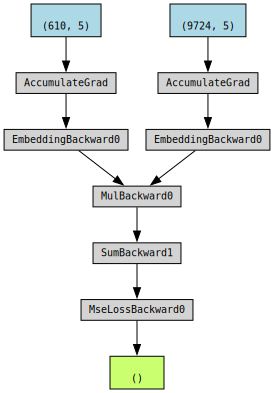

In [11]:
make_dot(loss)

In [16]:
X_test = torch.tensor(test_data[['userId', 'movieId']].values)
y_test = torch.tensor(test_data['rating'].values.astype(np.float32))

model.eval()
test_loss = 0.0
absolute_errors = []
with torch.no_grad():
    predictions = model(X_test)
    loss = criterion(predictions, y_test)
    

print(f"Test Loss: {test_loss / len(X_test)}")
print(f"Test MAE: {np.abs((predictions - y_test).tolist()).mean()}")
print(f"Test MAE: {mean_absolute_error(y_test, predictions)}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, predictions))}")


Test Loss: 0.0
Test MAE: 0.8452265566183148
Test MAE: 0.8452265858650208
Test RMSE: 1.2780202627182007


### With Dataloader

In [18]:
class MovieLensDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe[['userId', 'movieId']].values
        self.ratings = dataframe['rating'].values.astype(np.float32)
        
        # It is faster (at least 2x) to use numpy arrays instead of a dataframe as below
        # and access the data in __getitem__ using iloc
        #self.data = dataframe[['userId', 'movieId']]
        #self.ratings = dataframe['rating']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.LongTensor(self.data[idx]), torch.FloatTensor([self.ratings[idx]])

In [39]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.1)

# Initialize dataset and data loaders
train_dataset = MovieLensDataset(train_data)
test_dataset = MovieLensDataset(test_data)

n_samples = len(train_data)
# Note: Setting batch_size larger values will decrease the time of a single epoch but after
# a certain value it does not further decrease. In the extreme even if you set batch_size to n_samples
# the running time of a single epoch will still be significant. This is probably because of the overhead
# sourced by dataset loader.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [40]:
# Initialize the model and optimizer
num_users = len(user_ids)
num_movies = len(movie_ids)
model = MatrixFactorization(num_users, num_movies, embedding_size=10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")
#model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

# Training loop
num_epochs = 10

import time
start = time.time()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    absolute_errors = []

    for batch_idx, (X, y) in enumerate(train_loader):
        #X = X.to(device)
        #y = y.to(device)
        predictions = model(X)
        loss = criterion(predictions, y.squeeze())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        absolute_errors.extend(torch.abs(predictions - y.squeeze()).tolist())
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")
    print(f"Train MAE: {np.mean(absolute_errors)}")


end = time.time()
print("Elapsed time:", end - start)


Using device cpu.
Epoch 1/10, Loss: 12.102086466105263
Train MAE: 2.901769384524387
Epoch 2/10, Loss: 3.5102003144024123
Train MAE: 1.353004370287011
Epoch 3/10, Loss: 2.087010719743787
Train MAE: 1.0229356126174756
Epoch 4/10, Loss: 1.5477632239608066
Train MAE: 0.8890790826948399
Epoch 5/10, Loss: 1.2585167464956495
Train MAE: 0.8130854773423825
Epoch 6/10, Loss: 1.0828765742901099
Train MAE: 0.7653017575768505
Epoch 7/10, Loss: 0.961940820698005
Train MAE: 0.7306597642784436
Epoch 8/10, Loss: 0.8742180279231458
Train MAE: 0.7035524221091191
Epoch 9/10, Loss: 0.8109221578705714
Train MAE: 0.6841327615974836
Epoch 10/10, Loss: 0.7630794320113652
Train MAE: 0.6670970934875341
Elapsed time: 51.30553197860718


In [41]:
# Evaluation on the test set
test_loss = 0.0
absolute_errors = []
with torch.no_grad():
    for batch_idx, (X, y) in enumerate(test_loader):
        predictions = model(X)
        loss = criterion(predictions, y.squeeze())
        test_loss += loss.item()
        absolute_errors.extend(torch.abs(predictions - y.squeeze()).tolist())

print(f"Test Loss: {test_loss / len(test_loader)}")
print(f"Test MAE: {np.mean(absolute_errors)}")

Test Loss: 1.7731850219395342
Test MAE: 0.8969225770291805


### What is going on under the hood?

Some explanations in order to understand what is going on during the computation.

In [32]:
criterion = nn.MSELoss()
num_users = len(user_ids)
num_movies = len(movie_ids)
model = MatrixFactorization(num_users, num_movies, embedding_size=5)
n_samples = len(train_data)
X = torch.tensor(train_data[['userId', 'movieId']].values)
y = torch.tensor(train_data['rating'].values.astype(np.float32))
permutation = torch.randperm(n_samples)
indices = permutation[0:0+32]
batch_X, batch_y = X[indices], y[indices]
predictions = model(batch_X)
loss = criterion(predictions, batch_y)

X contains the indices of pairs of users and movies.

In [55]:
X[:3]

tensor([[ 42, 343],
        [302, 757],
        [501,  71]])

Select a set of users and movies

In [45]:
uidx = torch.tensor([0,1,2])
iidx = torch.tensor([6,7,8])

In [46]:
user_emb = model.user_embedding(uidx)
user_emb

tensor([[-1.0025, -0.4543, -0.7436,  1.6553,  1.9770],
        [-0.1971,  0.0846, -0.6548,  1.4419,  1.4326],
        [-0.8921, -1.0224, -0.3187,  0.2523,  0.4210]],
       grad_fn=<EmbeddingBackward0>)

In [47]:
movie_emb = model.movie_embedding(iidx)
movie_emb

tensor([[-0.0895, -1.1188, -0.7012,  1.8861,  0.7449],
        [-0.8070, -0.8636, -0.1842,  0.4362,  1.6826],
        [-0.1349, -0.9455, -1.8755,  0.2066,  1.1307]],
       grad_fn=<EmbeddingBackward0>)

Find their dot product by first element-wise multiplication then sum along the x dimension

In [50]:
mul = user_emb * movie_emb
mul

tensor([[ 0.0897,  0.5083,  0.5214,  3.1219,  1.4727],
        [ 0.1591, -0.0731,  0.1206,  0.6290,  2.4105],
        [ 0.1204,  0.9667,  0.5977,  0.0521,  0.4760]], grad_fn=<MulBackward0>)

In [52]:
torch.sum(mul, dim=1)

tensor([5.7140, 3.2461, 2.2128], grad_fn=<SumBackward1>)

You can check that

In [53]:
sum([ 0.0897,  0.5083,  0.5214,  3.1219,  1.4727])

5.7139999999999995